# **LoRA Fine-Tuning with Distributed Data Parallel (DDP) Notebook**

### **LoRA Fine-Tuning with Distributed Data Parallel Readme:**

For more information on LoRA Fine-Tuning with Distributed Data Parallel, refer to the [LoRA Fine-Tuning with Distributed Data Parallel Readme](../lora_finetuning_with_ddp_readme.md).

### **About This Notebook:**

This notebook demonstrates `LoRA Fine-Tuning with Distributed Data Parallel`. Compared to the [LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning.ipynb), the following modifications have been made:

1. A custom device map was created for multi-GPU training in Distributed Data Parallel. During training, multiple ranks (processes) are initiated in parallel, with each rank allocating its model layers to the GPU it is bound to.

2. An optional custom callback function is defined to validate data parallelism in DDP. At the first training step, this callback reports VRAM usage and prints details of the mini-batch dispatched to the current rank, including the mini-batch size and the first data in the mini-batch. These details confirm that each rank (GPU) processes a distinct batch of data from the dataset, ensuring proper data parallelism.

3. LoRA fine-tuning-related pre-training and training steps are encapsulated in a workflow function. The following modifications were added to support DDP:  
   3.1. Initialize an accelerator to provide the current rank (process) ID, which helps bind the current rank to its corresponding GPU.  
   3.2. Override the `print()` function to prepend a prefix string. This ensures individual rank outputs can be identified even when all ranks' outputs are mixed in the terminal, facilitating debugging.  
   3.3. Use only the main rank (rank 0, GPU 0) for specific tasks such as account logins, file writing, and model inference to avoid redundant logins and file conflicts in multi-process environments.  
   3.4. Apply additional trainer configurations for DDP, including enabling non-reentrant gradient checkpointing for faster backward passes and disabling checks for unused parameters to reduce computational overhead.  
   3.5. Unlike standard multi-GPU training, this notebook does not apply learning rate scaling. Typically, the learning rate increases proportionally with the batch size. In this notebook, the effective batch size during training scales up linearly with the GPU count allocated for training. However, in LoRA fine-tuning, less aggressive updates are required as fewer parameters are modified. Consequently, no scaling or minimal scaling is sufficient, as LoRA adapters generally perform well with smaller learning rates.

4. Since the training workflow function is saved in an external Python file, removing the Python cache folder (`__pycache__`) and restarting the kernel after modifying the workflow content ensures that the notebook does not pick up old cached content.

5. Two approaches are demonstrated to execute the training workflow function: using `notebook_launcher` or `accelerate launch`.

### **Supporting Python Files:**

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_lora_finetuning_with_ddp.py`: Contains utility functions specific to LoRA fine-tuning with Distributed Data Parallel. Created within this notebook.
- `my_workflow_lora_finetuning_with_ddp.py`: Contains a workflow function that encapsulates LoRA fine-tuning-related pre-training and training steps, along with the modifications required for DDP. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The specific configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 150GB (model checkpoints storage)
- `GPU Setup`: 4 Nvidia A6000 GPUs (48GB VRAM)

---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook


Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training & Training**

## 2.1 Define Utility Functions for LoRA Fine-Tuning with Distributed Data Parallel

In [1]:
%%writefile my_utils_lora_finetuning_with_ddp.py
#--------------- Functions in LoRA Fine-Tuning with Distributed Data Parallel ---------------
# 1) Override the built-in print() function to prepend a prefix string to all printed messages.
import builtins
def add_prefix_to_print_function(prefix_string):
    original_print = builtins.print                               # Save a reference to the original print function
    def custom_print(*args, **kwargs):                            # Define a custom print function
        args = (f"{prefix_string} {' '.join(map(str, args))}",)   # Prepend the prefix string to the original print message
        original_print(*args, **kwargs)                           # Call the original print function with the modified arguments
    builtins.print = custom_print                                 # Override the built-in print function

# 2) Create Custom Device Map (Multi-GPU) for Distributed Data Parallel
def create_device_map_ddp_multi_gpu(accelerator):
    rank = accelerator.process_index                              # Get the current rank (process) ID from the accelerator
    device_map = {'': rank}                                       # Allocate all model layers to the GPU matching the current rank ID
    return device_map

# 3) Create Custom Device Map (Single-GPU)
def create_device_map_ddp_single_gpu0():   
    device_map = {'': 0}                                          # Allocate all model layers to the single GPU0
    return device_map

# 4) Define a custom callback function to report VRAM usage, print the mini-batch size, and print the first data in the mini-batch.
# Note: At every training step, each GPU receives an individual mini-batch from the dataloader in DDP. Printing the mini-batch size and the first data in the mini-batch at training step 1 helps validate that each GPU processes a different batch from the dataset, ensuring proper data parallelism.
import torch
from transformers import TrainerCallback
class CustomCallbackDDP(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        # If the current process is using a GPU and this is the first training step:
        if torch.cuda.is_available() and state.global_step == 1:
            # Report VRAM usage
            gpu_id = torch.cuda.current_device()
            gpu_memory = torch.cuda.memory_allocated(gpu_id) / (1024 ** 3)
            gpu_max_memory = torch.cuda.max_memory_allocated(gpu_id) / (1024 ** 3)
            total_memory = torch.cuda.get_device_properties(gpu_id).total_memory / (1024 ** 3)
            print(f'Step {state.global_step}: Current VRAM usage: {gpu_memory:.2f} GB, Peak VRAM usage: {gpu_max_memory:.2f} GB, Total GPU VRAM: {total_memory:.2f} GB')

            # Print mini-batch size and the first data in the mini-batch
            train_dataloader = kwargs.get('train_dataloader')     # Retrieve the dataloader from kwargs
            if train_dataloader is not None:
                for batch in train_dataloader:
                    input_data = batch.get('input_ids', None)
                    if input_data is not None:
                        batch_size = input_data.size(0)           # Get the size of the mini-batch
                        first_input_data = input_data[0].tolist() # Convert the first data in the mini-batch to a list
                        print(f'Step {state.global_step}: Mini-batch size: {batch_size}')
                        print(f'Step {state.global_step}: 1st data in mini-batch: {first_input_data}')
                    else:
                        print(f'Step {state.global_step}: No input data available in the mini-batch.')
                    break                                         # Stop after processing the first mini-batch to avoid iterating through the entire dataloader

Writing my_utils_lora_finetuning_with_ddp.py


## 2.2 Wrap Pre-Training and Training Steps into a Training Workflow Function

In [2]:
%%writefile my_workflow_lora_finetuning_with_ddp.py
#--------------- A Training Workflow in LoRA Fine-Tuning with Distributed Data Parallel ---------------
def training_workflow():
    import my_login
    import my_utils
    import my_utils_lora_finetuning_with_ddp

    # **Step 1: Rank (Process) Initialization**
    ## 1.1 Initialize an Accelerator at the Beginning of Each Rank (Process)
    import torch
    from accelerate import Accelerator
    accelerator = Accelerator()
    rank = accelerator.process_index                  # Get the current rank (process) ID
    torch.cuda.set_device(rank)                       # Bind the current rank (process) to the GPU with the same ID (e.g., rank 0 to GPU 0, rank 1 to GPU 1, etc.)

    ## 1.2 Override print() to Prepend a Prefix String ('[RANK{current rank ID}:GPU{current GPU ID}]') to All Printed Messages
    gpu_id = torch.cuda.current_device()
    prefix_string = f'[RANK{rank}:GPU{gpu_id}]'
    my_utils_lora_finetuning_with_ddp.add_prefix_to_print_function(prefix_string)
    print(f'==> Process started...')

    # **Step 2: Pre-training**
    ## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases)
    if accelerator.is_main_process:                                        # Only use rank 0 to log in to avoid multiple logins
        # Log in to the Hugging Face account to access the Idefics2 model and the dataset
        my_login.login_hf()
        # Log in to the Weights & Biases account to enable tracking of training progress
        my_login.login_wandb()
    accelerator.wait_for_everyone()                                        # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.2 Load the Processor (Tokenizer) and the Base Model
    # Load processor
    processor = my_utils.load_processor()
    # Load model
    base_model = my_utils.load_model(device_map=my_utils_lora_finetuning_with_ddp.create_device_map_ddp_multi_gpu(accelerator))  # Use a custom device map: The model processed in the current rank (process) should be allocated to the GPU bound to this rank. Thus, all model layers are allocated to the GPU matching the current rank ID.
    if accelerator.is_main_process:                                        # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')
        my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
        my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')
    accelerator.wait_for_everyone()                                        # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.3 Load the Dataset
    # Load the Hugging Face dataset
    dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

    ## 2.4 Perform Inference with the Base Model to Establish a Baseline
    if accelerator.is_main_process:                                        # Only use rank 0 to run inference to avoid multi-process file writing
        # Perform batch inference on the test set and save results to a CSV file
        my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 14)
        # Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
        my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')],
                                        thumbnail_dir='./results/inference_results/thumbnail',
                                        plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg'
        )
    accelerator.wait_for_everyone()                                        # Synchronize across all ranks to ensure rank 0 finishes

    # **Step 3: Training**
    ## 3.1 Add a Custom Padding Token
    # Set up pad token (<pad>) in the processor
    my_utils.setup_pad_token_in_processor(processor)
    # Set up pad token (<pad>) in the base model
    my_utils.setup_pad_token_in_model(base_model, processor)

    ## 3.2 Create a LoRA Adapter
    # Create LoRA adapter with rank=8 and lora_alpha=64
    lora_model = my_utils.create_lora_adapter(base_model, 8, 64)
    if accelerator.is_main_process:                                         # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_model_info_to_file(lora_model, './results/model_info/lora_model_info.txt')
        my_utils.print_model_parameters_to_file(lora_model, './results/model_info/lora_model_parameters.txt')
    accelerator.wait_for_everyone()                                         # Synchronize across all ranks to ensure rank 0 finishes

    ## 3.3 Set Up the Trainer
    custom_callback = my_utils_lora_finetuning_with_ddp.CustomCallbackDDP() # Optional: Reports VRAM usage and validates data parallelism by printing mini-batch details during the first training step.
    trainer = my_utils.setup_trainer(lora_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=14, callbacks=[custom_callback])
    # Additional trainer setup in LoRA Fine-Tuning with DDP
    trainer.args.gradient_checkpointing_kwargs = {'use_reentrant': False}   # In DDP, use a non-reentrant backward pass to skip extra autograd graph traversals, making the backward pass faster.
    trainer.args.ddp_find_unused_parameters = False                         # Skip unnecessary checks for unused parameters to reduce overhead during backward computation

    ## 3.4 Train the Model
    my_utils.run_training(lora_model, trainer)

if __name__ == "__main__":
    training_workflow()

Writing my_workflow_lora_finetuning_with_ddp.py


## 2.3 Execute the Training Workflow Function

This notebook will initialize multiple ranks (processes) in parallel. Each rank will execute an individual training workflow on the GPU to which it is bound.

There are two approaches to execute the training workflow function: use `notebook_launcher` or use `accelerate launch`.

### **(Approach 1) Use `notebook_launcher` to Execute the Training Workflow Function:**

- Notebook Launcher Tutorial: [HF: Launching distributed training from Jupyter Notebooks](https://huggingface.co/docs/accelerate/main/en/basic_tutorials/notebook#using-the-notebooklauncher)
- Notebook Launcher Reference: [HF: Launchers](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher)


In [ ]:
from accelerate import notebook_launcher
import my_workflow_lora_finetuning_with_ddp

# Execute the training workflow function
notebook_launcher(my_workflow_lora_finetuning_with_ddp.training_workflow, num_processes=4)  # Allocate 4 ranks (processes, GPUs) to execute the training workflow in parallel

### **(Approach 2) Use `accelerate launch` to Execute the Training Workflow Function:**

- Accelerate Launch Reference: [HF: accelerate launch](https://huggingface.co/docs/accelerate/main/en/package_reference/cli#accelerate-launch)


In [3]:
# Execute the training workflow function
!accelerate launch --num_processes=4 my_workflow_lora_finetuning_with_ddp.py  # Allocate 4 ranks (processes, GPUs) to execute the training workflow in parallel

The following values were not passed to `accelerate launch` and had defaults used instead:
		More than one GPU was found, enabling multi-GPU training.
		If this was unintended please pass in `--num_processes=1`.
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
[RANK0:GPU0] ==> Process started...
[RANK0:GPU0] ==> Logging in to Hugging Face...
[RANK0:GPU0] The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
[RANK0:GPU0] Token is valid 

---
# **Step 3: Post-Training**

## 3.1 Restart Kernel for a Clean Environment

## 3.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. This fine-tuned model will be used for further inference to assess improvements in model performance.

For post-training inference, a single GPU is sufficient, and there is no need to allocate multiple GPUs as was done during the training stage. Therefore, the model is loaded onto `GPU0`.


In [1]:
# Load functions
import my_login
import my_utils
import my_utils_lora_finetuning_with_ddp

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
base_model = my_utils.load_model(device_map=my_utils_lora_finetuning_with_ddp.create_device_map_ddp_single_gpu0())

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(base_model, processor)

# Load LoRA adapter from a checkpoint with the minimum loss
lora_model = my_utils.load_lora_adapter_from_checkpoint(base_model, './results/training_checkpoints/checkpoint-45')


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Loading processor...
==> Loading model...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.
==> Loading LoRA adapter from checkpoint...


## 3.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/6] Data in batch: 14
==> [Batch: 1/6][Data: 1/14] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


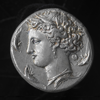

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, a stunning silver coin from the late 5th century BCE, celebrated for its exquisite artistry and high relief, crafted by renowned artists like Kimon and Euinatos. The coin's intricate design has captivated collectors for over two and a half millennia, leading to the question of how the ancient Greeks achieved such beauty with only hand tools. The dekadrachm's intriguing history includes its use as a model for modern coin design, with Theodore Roosevelt's reformative efforts aimed at enhancing the aesthetic appeal of American currency. This particular coin is part of the National Numismatic Collection at the National Museum of American History, where it serves as a t

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


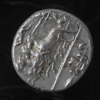

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, a remarkable coin from the late 5th century BCE, celebrated for its exquisite artistry and high relief, crafted by renowned artists like Kimon and Euinatos. The coin's intriguing history includes its admiration by Theodore Roosevelt, a U.S. president known for his reformative policies. Roosevelt was not only a political leader but also a passionate advocate for American currency, believing it should reflect the nation's artistic and cultural values. Displeased with the mundane appearance of contemporary American coins, he sought to elevate their design, comparing it unfavorably to classical coins like the dekadrachm. His vision led to a partners

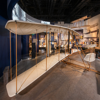

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, the first successful powered aircraft in history. Constructed by Wilbur and Orville Wright, it is powered by a 12-horsepower engine and utilizes a unique sprocket-and-chain system to drive its two pusher propellers. The Flyer is notable for its lack of wheels, relying instead on skids for landing and featuring a unique "teetering" design that allows it to maintain stability during flight. Its historic first flight occurred on December 17, 1903, at Kitty Hawk, North Carolina, where it achieved a 36-meter flight in just 12 seconds. The Wright brothers' groundbreaking work in aeronautical engineering, which included the development of wind tunnel testing and the innovat

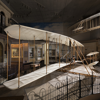

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wright Flyer, the first successful powered aircraft to carry a pilot, which made its historic flight on December 17, 1903, at Kitty Hawk, North Carolina. Constructed by Wilbur and Orville Wright, the Flyer is a biplane with a 12-horsepower engine and utilizes a sprocket-and-chain system to drive its two pusher propellers. It employs non-wheeled skids for landing and is distinguished by its lack of wingspan braces. The Wright brothers' groundbreaking research in aeronautical engineering, which began in 1899, included the development of wind tunnel testing and innovative control methods, leading to this remarkable achievement. The Flyer's first flight lasted just 12 s

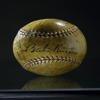

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the 1926 New York Yankees, signed by Hall of Famers Babe Ruth and Lou Gehrig. Ruth, a celebrated slugger, and Gehrig, known for his remarkable streak of 2,130 consecutive games, are both pivotal figures in baseball history. Gehrig's battle with amyotrophic lateral sclerosis (ALS), often referred to as Lou Gehrig's disease, highlighted his courage and humility, making him a revered figure across the nation. The baseball itself is a cork center, layered with wool, and covered in horsehide, with a diameter of 3 inches. Although it is not currently on display, this artifact is part of the National Museum of American History's collection, generously donated by the E

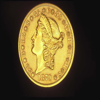

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin from the United States Mint in Philadelphia, minted in 1879 and cataloged as Judd 1643. The coin showcases a Liberty head on the obverse, with the date and specifications inscribed around it. The reverse side is adorned with an eagle, but it notably includes the Latin motto DEO EST GLORIA instead of the usual IN GOD WE TRUST. This design was part of an initiative to enhance the competitiveness of American coinage in the global market, similar to the introduction of the four-dollar gold coin, the Stella. Only nine of these gold coins are known to exist, including this one, which was last sold at auction in 2008. The coin measures .2 cm by 3.4 cm and is currently not o

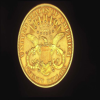

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin from the United States Mint in Philadelphia, dating back to 1879. The coin is notable for its design, which includes a left-facing Liberty head on the obverse and an eagle, emblazoned with the Latin motto "DEO EST GLORIA," on the reverse. This design was part of an initiative aimed at enhancing the competitiveness of American currency in the global market, similar to the four-dollar gold coin known as the Stella. Only nine of these coins are recorded, including this one, which was transferred from the U.S. Mint to the National Museum of American History in 1994. It measures .2 cm by 3.4 cm and is currently not on display.
==> Ground truth answer: 

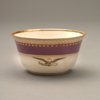

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, an artifact that carries deep historical significance. On April 14, 1865, just before attending Ford's Theatre for the last time, President Lincoln inadvertently left this cup on a windowsill. A White House servant preserved it as a relic of that tragic night, and it was later given to Robert Todd Lincoln, the president's eldest son, by Capt. D.W. Taylor in 1887. This cup, made of ceramic and measuring approximately 3 1/4 inches in height, is part of the collection at the Smithsonian's National Museum of American History, thanks to a donation from Lincoln Isham, Lincoln's great-grandson, in 1958. It serves as a poignant reminder of Lincoln's legacy and the tum

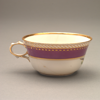

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, an artifact that carries deep historical significance. The cup was left behind by President Lincoln on the evening of April 14, 1865, just before he attended Ford's Theatre for the last time. A White House servant preserved the cup as a relic of that tragic night, and it was later given to Robert Todd Lincoln, Lincoln's eldest son, by Capt. D.W. Taylor in 1887. The cup is made of ceramic and features a striking design in purple with white and gold trim, measuring approximately 3 1/4 inches in height. It is part of the collection at the Smithsonian's National Museum of American History, where it serves as a poignant reminder of Lincoln's leg

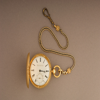

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite watch served as a symbol of his success as a lawyer. The movement, crafted in Liverpool, a renowned watchmaking city, is of the highest quality, capable of keeping time with remarkable accuracy. The case, made in the United States, showcases a unique design with a curved glass cover, a distinctive feature among watches of that era. A poignant story surrounds the watch's history—on April 12, 1861, while Lincoln was wearing it, news of the Confederate attack on Fort Sumter reached him. He later inscribed a m

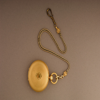

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite watch served as a symbol of his success as a lawyer. The movement, crafted in Liverpool, a renowned watchmaking city, is of the highest quality, capable of keeping time to within seconds daily. The case, made by an unidentified American manufacturer, is adorned with a beautiful 18K gold finish and features a unique design with a curved glass cover. A fascinating aspect of this watch is its hidden message engraved by watchmaker Jonathan Dillon on April 12, 1861, the day of the Confederat

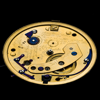

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. The watch is notable not only for its craftsmanship—made with an 18K gold case and a movement crafted in Liverpool—but also for its sentimental value to Lincoln. A fascinating story accompanies the watch's history: on April 12, 1861, just as the Civil War began, a watchmaker engraved a hidden message inside the watch, commemorating the attack on Fort Sumter. This message remained undiscovered for over a century until it was revealed in 2009. The watch was later gifted to the Smithsonian's National Museum of Amer

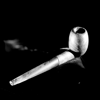

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Albert Einstein's pipe from circa 1948, a significant artifact housed at the Smithsonian's National Museum of American History. Einstein, a renowned physicist and Nobel Prize laureate, is equally recognized for his distinctive appearance, often characterized by his pipe. Although he reduced his smoking later in life for health reasons, he cherished the experience of holding a pipe. This particular pipe shows signs of extensive use, including a hole worn into the bit, and was gifted to Gina Plunguian, a close friend of Einstein. The Smithsonian acquired this piece in 1979, and it stands as a testament to Einstein's enduring influence on science and culture. It is part of a larger collection

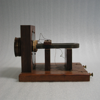

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell, who received the first patent for his device on March 7, 1876. Just three days later, Bell successfully communicated with his assistant, Thomas Watson, marking a pivotal moment in communication history. The exhibit features one of the two telephones used during a demonstration between Boston and Salem on November 26, 1876. This particular telephone is notable for its design, which includes an iron diaphragm and two electromagnets, lacking the wooden casing found on many other telephones in the Smithsonian's collection. Acquired from the American Telephone & Telegraph Co. in 

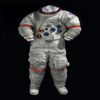

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apollo 17 spacesuit, an iconic artifact from the last Apollo mission that landed astronauts on the moon in December 1972. The mission was launched on December 7, 1972, by a Saturn V rocket and included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, who was the first geologist to walk on the moon. While Evans remained in lunar orbit, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region and conducted three moonwalks over three days, collecting a record 110 kilograms of lunar samples and driving a lunar rover for 35 kilometers. Their mission concluded with a Pacific Ocean landing on December 19, 1972. Cerna

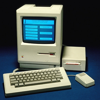

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the Smithsonian's National Museum of American History highlights the Apple "Classic" Macintosh Personal Computer, which made its debut in January 1984. Apple Inc. introduced a revolutionary graphic user interface that allowed users to navigate their computers using icons instead of command lines, a concept initially developed at Xerox's Palo Alto Research Center. The Macintosh's launch was accompanied by a significant advertising campaign, including a Super Bowl XVIII advertisement, which cost around $9 million. The initial model was priced at approximately $2,500 and featured a 128K microprocessor operating at 8 MHz, 512 KB of RAM, and a 400 KB floppy disk drive. The Macintosh 512 KB, released 

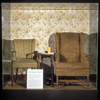

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an upholstered wing chair that was used by Archie Bunker, played by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, which is upholstered in a vibrant orange-yellow woven fabric and supported by a sturdy wooden frame, is believed to have been made in the 1940s. It was acquired from a thrift store in Southern California and became a key piece in the show's narrative, representing the Bunker family's living room. "All in the Family," which aired from 1971 to 1979, was a revolutionary sitcom that addressed pressing social issues of the time, including racism and gender equality. The show's success is evident in its 22 Emmy awards and the spinoff series

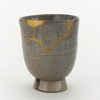

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable tea bowl from the 17th century, originating from the White Satsuma ware collection of Kagoshima prefecture, Japan, during the Edo period. The bowl, crafted from stoneware and adorned with a clear, crackled glaze, showcases the artistry of kintsugi, a traditional Japanese repair technique that highlights rather than conceals damage. Kintsugi employs lacquer, a natural resin derived from tree sap, which, once cured, exhibits remarkable strength and water resistance. The lacquer repairs are embellished with powdered gold, enhancing the bowl's aesthetic appeal. This technique not only restores the bowl but also transforms its narrative, making the scars of its past a celebrated pa

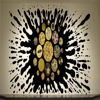

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the captivating work of Yinka Shonibare, an artist born in London in 1962. It showcases a collection of 25 circular canvases, each varying in size, arranged against a large-scale ink splatter pattern applied with a template. The canvases are adorned with foliate patterns in black and gold, crafted using Dutch wax printed fabrics. Shonibare's artistic journey is evident as he transitions from grid-like square canvases to these dynamic roundels, which challenge conventional boundaries. The splatter effect is a nod to Jackson Pollock's abstract expressionist style, yet it is applied with a template, making it a playful yet controlled technique. The work references Africa's valuable oil resour

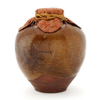

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable tea-leaf storage jar from the 17th century, originating from the White Satsuma style of Kagoshima prefecture, Japan, during the Edo period. The jar is characterized by its unique design, which includes a wide, flat shape and a high, curved mouth, along with a distinctive green and orange color scheme. A notable feature is the antique Chinese fabric cover that adorns the jar, adding a layer of cultural significance to its presentation. The piece is part of the Smithsonian's Freer Gallery of Art collection, where it is showcased in the “Chigusa and the Art of Tea” exhibition, which explores the intersection of Japanese tea culture and the artistry of objects associated with it. 

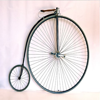

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito high-wheel bicycle, an emblematic artifact from 1886, crafted by the Pope Manufacturing Co., the first bicycle manufacturer in the United States. The bicycle is notable for its 53-inch front wheel, which is equipped with 60 spokes, and an 18-inch rear wheel with 20 spokes, showcasing the variety of sizes available to cyclists at the time. Accompanying the bicycle is a historic photograph from 1879, capturing one of the earliest organized biking tours in America, featuring Charles E. Pratt, the inaugural president of the League of American Wheelmen, who is seen leading the group outside Readville, Massachusetts. The Smithsonian's cycle collection, established in 1889, includes 60

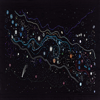

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Milky Way, Starry Night #2," a striking work by Gwich'in artist Margaret Nazon from Tsiigehtchic, Northwest Territories, Canada, created in 2021. Nazon's artistic journey began later in life when she was inspired by the beauty of the night sky, which she first witnessed while attending a star party. Her artwork reflects her passion for astronomy, showcasing swirling galaxies and stars, a departure from traditional Gwich'in beadwork themes. This piece was made for the "Lights Out: Recovering Our Night Sky" exhibition at the Smithsonian's National Museum of Natural History, where it will eventually be added to the museum's collection. The "Lights Out" exhibition highlights the significance 

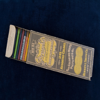

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a pack of Crayola Crayons from 1951, celebrating a beloved American invention that has inspired creativity in children for generations. The crayons were created by the Binney & Smith Company in Easton, Pennsylvania, and were crafted from paraffin wax and non-toxic pigments, ensuring they were safe and durable. The name "Crayola," conceived by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," reflecting their waxy texture. The box, designed with a simple illustration of a girl coloring, originally contained 28 colors, including burnt sienna and golden ochre, but now includes 22 crayons. The box's historical context is further enriched by a 1903 advertisement from

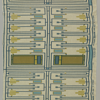

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning textile designed by the renowned Frank Lloyd Wright, an American visionary who lived from 1867 to 1959. The piece was produced by F. Schumacher & Co., a prominent New York-based manufacturer established in 1889. It showcases a geometric pattern composed of rectangular blocks in soothing shades of light blue and olive, interconnected by fine lines of darker blue on an off-white background. The textile measures 120 cm in height and 57.5 cm in width (47 1/4 in. by 22 5/8 in.), with a repeat height of 63.5 cm (25 in.). Additionally, four alternative colorways are displayed on the upper back of the piece. This textile is made from 100% cotton and features a screen printing technique 

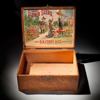

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, showcasing the historical significance of seed packets and their marketing strategies. In the 19th century, seed packets were often displayed in wooden boxes, each designed with eye-catching labels that served as silent salesmen. These boxes were found in general stores, where they not only organized seed packets but also functioned as promotional tools. The D.M. Ferry & Co. seed box, specifically from the 1890s, is notable for its construction from wood, paint, and paper, measuring 12 x 10 x 5 inches. This piece is part of the Smithsonian's collection, although it is not currently on display. The history of seed packets and their advertising methods is 

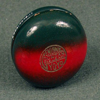

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a vintage yo-yo from the 1930s, crafted by the Duncan Toys Company in Chicago, Illinois. The yo-yo is made from wood, featuring a green design with a bold red stripe, and is equipped with a seal that reads "Genuine Duncan Yo-Yo, Reg. US Pat." This item is part of the National Museum of American History's collection, donated by Donald F. Duncan Sr., who played a significant role in popularizing the toy in the United States. The story of the yo-yo begins in 1928 when Duncan discovered the toy in San Francisco, where it was being marketed by Pedro Flores, a Filipino immigrant. Flores had already begun producing wooden yo-yos and had created a demand by demonstrating the tricks associated with

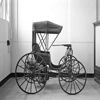

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1893-94 Duryea automobile, a pivotal artifact in the history of American transportation. In 1893, Frank Duryea conducted a road test on this vehicle, which was the first American automobile to operate on public roads. The Duryea is powered by a one-cylinder, four-cycle, four-horsepower water-cooled gasoline engine, which is positioned nearly horizontally beneath the carriage. It also includes a gear transmission, a spray carburetor, and a make-and-break ignition system. The automobile was acquired by the Smithsonian's National Museum of American History in 1920 and was restored in 1958, showcasing the technological advancements of its time.
==> Ground truth answer: The exhibit features

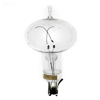

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb, an invention that revolutionized lighting technology. Invented by Thomas Edison in 1879, this carbon-filament bulb was the first practical electric incandescent lamp. Its operation is based on the principle of electrical resistance heating, where an electric current passes through a metal filament, causing it to glow. To protect the filament from air exposure, it is enclosed in a glass bulb filled with inert gas. This landmark invention was unveiled during Edison's first public demonstration of the “invention factory” he established in Menlo Park, New Jersey. Edison's legacy as a quintessential American inventor is often overshadowed by the misconception that he was 

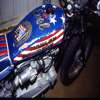

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Evel Knievel's 1972 Harley-Davidson XR-750, a motorcycle that symbolizes the daring spirit of its rider. Evel Knievel, born Robert Craig Knievel, was a renowned American daredevil known for his thrilling stunts. Over his career, he captivated audiences with his daring motorcycle jumps, often resulting in serious injuries, including 35 to 40 broken bones. The XR-750, made from steel, aluminum, and fiberglass, weighed approximately 300 pounds and was instrumental in many of Knievel's performances. Notably, he used this motorcycle to jump over 14 Greyhound buses in 1975, a feat that showcased his extraordinary skills. The exhibit not only highlights Knievel's talent but also celebrates the ex

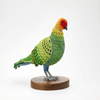

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Laurel Roth Hope's innovative work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. Hope employs humor to address the serious issue of species extinction through her “Biodiversity Reclamation Suits,” which allow ordinary rock pigeons to masquerade as extinct North American birds. Using traditional techniques like carving, embroidery, crochet, and collage, she transforms simple materials into intricate animal sculptures that not only captivate the eye but also prompt deeper reflection on the state of biodiversity. Hope's artistic process involves extensive research into the species she portrays, ensuring that he

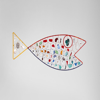

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Fish," a striking sculpture by Alexander Calder, created in 1945 and part of the Hirshhorn Museum and Sculpture Garden's collection in Washington, D.C. Calder, who was born into a family of artists, initially pursued a degree in mechanical engineering before fully committing to his artistic career. His journey included freelancing as an illustrator while studying at the Art Students League in New York, leading to his relocation to Paris, where he was influenced by avant-garde artists and began to create wire sculptures that critics described as “drawings in space.” In 1931, inspired by the simplicity of Piet Mondrian's studio, Calder invented the “mobile,” a kinetic sculpture that moves w

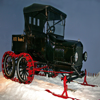

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of rural mail carriers in the early 20th century. As automobiles became the primary means of mail delivery, many carriers found themselves struggling in deep snow. To combat this, Virgil White developed a solution in 1906 by converting cars into snowmobiles, replacing front tires with skis and outfitting the rear with caterpillar treads. This innovation allowed for easier travel over snow and reduced reliance on horses and sleds during winter months. White's initial prototype utilized a Buick Model G, but as the Ford Model T gained popularity, he began offering kits specifically for it. By 1922, these ki

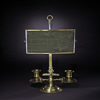

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: Thomas Jefferson's portable writing desk, which he used to draft the Declaration of Independence in 1776. As a delegate from Virginia, Jefferson was tasked with articulating the colonies' desire for independence from Britain, and he sought to create a document that would resonate with future generations. The desk, designed with a hinged writing board and a locking drawer for writing materials, was crafted by a Philadelphia cabinetmaker and features a green silk lining. Jefferson kept this desk throughout his life, using it to compose various important documents, including the Declaration of Independence and his own presidential addresses. In a poignant gesture, he l

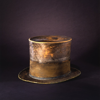

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features President Abraham Lincoln's top hat, an important artifact housed at the Smithsonian's National Museum of American History. Standing at 6'4”, Lincoln was already a towering figure, and his choice of high top hats further emphasized his stature. This particular hat was made by Washington hat maker J.Y. Davis and features a black silk mourning band, a tribute to his son Willie, who died in 1862. While the exact date of acquisition is unknown, it is believed that Lincoln last wore this hat on April 14, 1865, the night he attended Ford's Theatre. After his assassination, the War Department preserved the hat along with other belongings, and with Mary Lincoln's consent, it was transferred to the

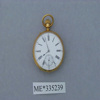

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket watch that belonged to Helen Keller, who was born on June 27, 1880. Keller, who lost her sight and hearing as a child, became a prominent advocate for disability rights and women's suffrage. She achieved remarkable success, including graduating from Radcliffe College in 1904, and her watch serves as a testament to her resilience and determination. The watch was gifted to her by John Hitz, the superintendent of the Volta Bureau, in 1892, and it was specially designed with pins around its edge to indicate the hours, making it accessible to someone who is blind. Keller cherished this watch throughout her life, even recovering it after a near loss in a taxi in 1952. The Smi

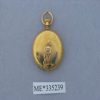

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite watch served as a symbol of his success as a lawyer. The movement, crafted in Liverpool, a renowned watchmaking city, is of the highest quality, capable of keeping time to within seconds each day. The case, made by an unidentified American manufacturer, is adorned with a beautiful 18K gold finish and features a glass window that allows for the observation of the movement. A poignant story accompanies this watch—on April 12, 1861, while Lincoln was wearing it, Confederate forces launched

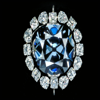

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., crafted in 1998. The centerpiece of the necklace is a primary gem, a modified antique cushion cut diamond weighing an impressive 45.52 carats. This diamond, which originates from India, showcases a dark gray-blue coloration that enhances its unique beauty. The necklace is expertly designed with 37 additional modified antique cushion cuts, each weighing between 0.1 and 0.2 carats, set in a pendante fashion. This exquisite piece of jewelry measures 1 3/4 inches in height and 5/8 inches in width, with a thickness of 1/8 inch. The necklace is made from a combination of gold and platinum, showcasing a high level of craftsmanship. It is currently not

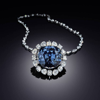

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond is of a dark gray-blue color and is skillfully cut in a modified antique cushion style, enhancing its unique characteristics. The necklace is crafted from a combination of platinum and diamonds, with the main gem set in a fashionable halo design. This exquisite piece is a gift from Mrs. Anne L. Bernat, and it is cataloged under the USNM Number NMNH G3551-00 and an IGSN of NHB002JKJ. The dimensions of the necklace are 1.8 cm by 1.3 cm by 5 cm, and it is currently on display at the National Museum of Natural History, Mineral Sciences Department.
==> G

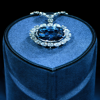

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond is of a dark gray-blue color and is skillfully cut in a modified antique cushion style, enhancing its unique characteristics. This exquisite piece is not only a testament to the beauty of gemstones but also a representation of the craftsmanship of Cartier, Inc. The gem's origin is not documented, and it is currently not on display. The record was last updated on September 26, 2022, and is cataloged under the USNM Number NMNH G3551-00 and an IGSN of NHB002JKJ.
==> Ground truth answer: On display is a captivating diam

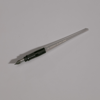

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable Esterbrook pen that holds historical significance as the instrument with which President Lyndon B. Johnson signed the Civil Rights Act of 1964 on July 2, 1964. This pen, along with thousands of others, was given to prominent figures in the Civil Rights Movement as a symbol of recognition. The journey to this landmark legislation was fraught with challenges, initially introduced by President John F. Kennedy before his assassination in November 1963. President Johnson's leadership was crucial in overcoming the bill's obstacles, including the longest filibuster in Congressional history, which lasted 57 days. The Civil Rights Act represented a vital first step toward equality, alt

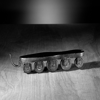

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate from 1823, crafted by Robert John Tyers. As the Winter Olympics approach, it's fascinating to reflect on how athletes in the 19th century prepared for competition without modern facilities. The Volito is notable for its unique design, which includes a wooden sole and a single row of five wooden wheels, complemented by a curved iron bar that functions as a basic brake. What sets this skate apart is its innovative wheel size—larger in the center and tapering at the ends—allowing for enhanced maneuverability during turns. This historical artifact is part of the National Museum of American History's collection, though it is currently not on display.
==> Ground truth

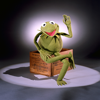

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a beloved character from The Muppet Show and Sesame Street, created by Jim Henson. Kermit first appeared in 1955 on Sam and Friends, and he has been performed by various puppeteers, including Jim Henson and Steve Whitmire, with Matt Vogel currently bringing him to life. Kermit is known for his calm and rational nature, often navigating the chaotic world around him with a wry sense of humor. His famous song, “Bein' Green,” reflects on the challenges he faces due to his color but ultimately celebrates his identity. The puppet is made from a variety of materials, including synthetic fiber, felt, plastic, and metal, and measures 27 inches in height. It is part of the Entertain

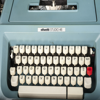

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), an acclaimed science fiction author whose work has left an indelible mark on literature. Butler is celebrated for her groundbreaking series, including the Patternist series and the Xenogenesis trilogy, as well as her thought-provoking novels such as Parable of the Sower and its sequel, Parable of the Talents, along with the collection Bloodchild and Other Stories. Her writing is characterized by a blend of African American history, speculative futures, and alien narratives, which collectively define the genre of Afrofuturism. By centering characters from the African diaspora in her early novels like Wild Seed and Kin

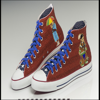

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Kiowa Ah-Day," a striking pair of sneakers created by Kiowa artist Teri Greeves in 2004. The sneakers are made from cotton canvas and commercial rubber, showcasing intricate overlay beadwork that highlights the artist's cultural heritage. Measuring 33 x 11 x 15 cm, this piece was purchased by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico, in 2004. It is part of the museum's collection, specifically within the category of "Native Knowledge 360º," which aims to provide educators and students with a deeper understanding of Native American history and culture through educational resources. The "Native Knowledge 360º" initiative was launched in 

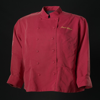

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant collection from the Smithsonian's National Museum of African American History and Culture, generously donated by Dooky Chase's Restaurant and Chef Leah Chase. Renowned as “The Queen of Creole Cuisine,” Chase is celebrated for her role in popularizing New Orleans Creole cooking worldwide. Together with her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop into a distinguished dining venue adorned with white tablecloths and African American art. The exhibit includes Chase's iconic red chef's jacket, a testament to her culinary achievements and contributions to civil rights. Visitors can also view her portrait on the Smithsonian's National Por

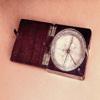

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket compass that belonged to William Clark, a key figure in the Lewis and Clark Expedition. Acquired in 1803 from Thomas Whitney in Philadelphia, the compass is crafted by Thomas Whitney and features a silver-plated brass rim graduated in degrees, a paper dial, and two brass sight vanes, all enclosed in a mahogany box with a leather carrying case. The compass is a testament to the scientific and exploratory spirit of early America, as it was carried by Meriwether Lewis during the expedition's journey to the northwestern territories at the directive of President Thomas Jefferson. Although many instruments were lost, this particular compass was cherished by Clark and later pr

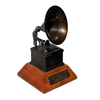

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Bob Newhart's 1960 Grammy Award, celebrating the illustrious career of the legendary comedian and actor. Born on September 5, 1929, in Oak Park, Illinois, Newhart has captivated audiences for over sixty years with his deadpan humor and insightful commentary on American life. His debut album, The Button-Down Mind of Bob Newhart, was a trailblazer, becoming the first comedy LP to reach No. 1 on the Billboard charts and winning him a Grammy for Album of the Year, along with the distinction of being the only comedian to win the Grammy for Best New Artist. Newhart's television career includes starring roles in The Bob Newhart Show and Newhart, both of which have become cultural touchstones. He 

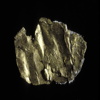

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant gold nugget from 1848, housed at the Smithsonian's National Museum of American History. This nugget is recognized as the first piece of gold discovered at Sutter's Mill in California, an event that sparked the gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall discovered a glimmering object in the mill's tailrace. Upon closer inspection, he identified it as a thin scale of pure gold. Marshall later presented this nugget to Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first gold discovered in Northern California. By August 1848, this nugget and other samples were sent to Washington, D.C., where Presi

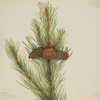

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a watercolor painting by Mary Vaux Walcott, created in 1921 and measuring 10 x 7 inches. It is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist requested her to paint a rare arnica flower. After marrying Charles Doolittle Walcott, the Secretary of the Smithsonian, in 1914, they spent summers in the Canadian Rockies, where she produced numerous watercolor studies of local flora. Her work gained recognition, leading to the publication of 400 illustrations in the five-volume series "North American Wild Flowers" from 1925 to 1929, and she illustrated "North American Pitcher Plants" in 193

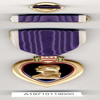

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the United States Purple Heart, a prestigious military decoration awarded to those who have been wounded or killed while serving in the U.S. Armed Forces. The medal is crafted in a heart shape, showcasing a gold relief of George Washington's profile against a striking purple enamel background. Above the bust is a shield that displays Washington's family coat of arms. The reverse side of the medal is inscribed with "FOR MILITARY MERIT," highlighting its significance. It is suspended from a silk ribbon that is purple with a white edge stripe. The medal is made from a combination of copper alloy, gold plating, and non-magnetic white metal alloy, with dimensions of 3.7 cm by 1.1 cm by 8.1 cm (

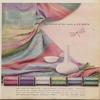

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating advertisement from the 1950s, showcasing the work of Dorothy Liebes, an influential American textile designer. The advertisement, which appears in the September 1953 issue of House & Garden, promotes Lurex, a metallic yarn produced by the Doorknob Company in New York. Liebes' innovative use of color and texture, along with her ability to create "subdued shimmers," contributed to the development of the modern American aesthetic known as the "Liebes Look." Her collaborations with notable architects and designers, including Frank Lloyd Wright, significantly impacted 20th-century design. Despite her acclaim during her lifetime, the full extent of her influence on 20th-century des

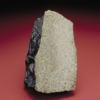

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Nakhla Meteorite Fragment, a significant specimen from Mars that fell to Earth on June 28, 1911, in the Nakhla region of Alexandria, Egypt. The meteorite's entry was dramatic, as many witnesses observed its explosive descent before it broke into approximately 40 pieces, collectively weighing 22 pounds, with some fragments buried up to a meter deep. The Smithsonian Institution was quick to acquire two samples shortly after the fall, and by 1962, a total of 650 grams had been amassed. The Nakhla meteorite is classified as a Nakhlite, a type of igneous rock rich in augite, formed from basaltic magma around 1.3 billion years ago. Studies have shown that these meteorites were influenced by 

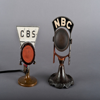

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, an essential artifact from President Franklin Delano Roosevelt's "Fireside Chats," which began on March 12, 1933. These informal radio addresses were pivotal during the Great Depression, allowing Roosevelt to connect with the American people in a way that no other president had. The first chat took place in the Lincoln Study, while subsequent ones were held in the Diplomatic Reception Room of the White House. This particular microphone, marked with the National Broadcasting Company logos, was preserved by Carleton Smith, who was responsible for its setup. The chats not only provided a sense of comfort to those listening but also helped shape public opinion and 

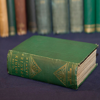

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "On the Origin of Species," a groundbreaking work by Charles Darwin published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the anniversary of the HMS Beagle's launch on May 11, 1820, a vessel that played a crucial role in Darwin's scientific endeavors. The Beagle was launched from Woolwich Dockyard in London and underwent modifications before its first voyage on December 27, 1831, where Darwin served as a young naturalist. Over five years, he meticulously documented fossils, plant specimens, and geological formations in South America and the Galápagos Islands, which led to his revolutionary theory of evolution by natural selection. The publicati

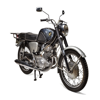

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a key artifact from his influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book sold a million copies in its first year alone, becoming a cultural touchstone that encouraged individuals to reevaluate their relationships with technology and seek a more balanced life. Pirsig's inspiration came from a transformative month-long motorcycle journey he undertook with his son Chris in 1968, during which they traveled 5,700 miles from Minnesota to San Francisco. This experience allowed Pirsig to reflect on the intricate connections between people and machines, leading to his groundbreakin

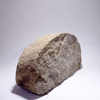

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Plymouth Rock Piece from 1620, an important artifact at the National Museum of American History. Traditionally recognized as the landing site of the Mayflower Pilgrims, Plymouth Rock is a significant piece of American history. William Bradford, the influential leader of the Plymouth Colony, is often credited with shaping Thanksgiving traditions in the United States. The rock's history is marked by its relocation in 1774, when it was moved from its original shoreline location to the town square, resulting in its division into two halves. The bottom half remained in its original spot, while the top half was taken to a meeting house. By 1880, the two halves were reunited, although several

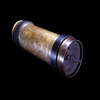

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953, showcasing the innovative postal system that emerged in the late 19th century. Pneumatic tube systems were installed beneath city streets, allowing for the swift transport of mail through cylindrical containers. Each canister could hold up to 500 letters and was propelled by compressed air, reaching speeds of approximately 35 miles per hour in a spinning motion. At its peak, the system moved an impressive six million pieces of mail daily, with five carriers dispatched every minute. The first pneumatic tubes were introduced in Philadelphia in 1893, followed by New York City in 1897, and later expanded to cities like Boston, Chicago, and St. Louis. By 

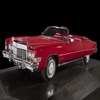

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the iconic red convertible Eldorado Cadillac from the 1972 model year, a quintessential symbol of American luxury and style. The Cadillac Eldorado was first introduced in 1948, named after the mythical city in the heart of the Arsenal of Democracy, and has been a staple of the Cadillac lineup, known for its elegant design and advanced features. The 1972 model showcases a 4.1-liter V8 engine, producing 170 horsepower, and is equipped with a three-speed automatic transmission, along with luxurious amenities such as air conditioning and power windows. This vehicle was famously driven by the character Archie Bunker, played by Carroll O'Connor, in the groundbreaking television series "All in th

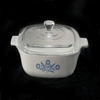

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a classic white casserole dish from CorningWare, dating back to 1965, adorned with the brand's iconic blue cornflower design. This dish is a testament to the company's innovative spirit, as it was crafted from Pyroceram—a glass-ceramic material that was initially developed for military applications during World War II. Its unique properties allowed it to withstand rapid temperature changes while being resistant to stains and odors, making it a versatile choice for cooking, freezing, and serving. This versatility, along with its affordable price, contributed to its widespread adoption in American kitchens. In the 1990s, CorningWare shifted its focus to ceramic stoneware 

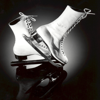

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of Sonja Henie, a legendary Norwegian figure skater from the late 1920s and 1930s. Henie was a trailblazer in the sport, introducing white leather skates to women's figure skating, a stark contrast to the traditional black skates. Her innovative approach, which included short skirts and choreographed performances, won her numerous accolades, including 10 consecutive world titles starting in 1927. She also triumphed in the Olympics, securing gold medals in ladies singles at the Winter Games held in 1928, 1932, and 1936. Henie's transition to Hollywood stardom in the 1930s saw her become a leading actress, starring in films like “One in a Million.” In 1976, she was

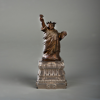

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable artifact: a miniature replica of the Statue of Liberty, often referred to as the American Committee Model. Produced in the United States, this statuette was created in large quantities to finance the construction of the statue's pedestal in New York Harbor. Designed by French sculptor Frédéric-Auguste Bartholdi, the model was available in both six-inch and twelve-inch sizes, with the six-inch version priced at one dollar and the twelve-inch version at five dollars. Richard Butler, a rubber manufacturer from New York, led the American Committee that oversaw the production of these models. The campaign not only popularized the image of Liberty across the nation and the world but

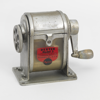

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to approximately 1920, crafted by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, this sharpener measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.) and is part of the Cooper Hewitt, Smithsonian Design Museum collection, gifted by Lucy Commoner. The Dexter Model 3 represents a significant advancement in pencil sharpener technology, featuring a rotating wheel with openings for various pencil sizes, a major improvement over its predecessor that only accommodated one size. This design innovation not only enhanced the sharpening experience for users but also set t

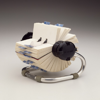

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Rolodex Open Rotary Card File, a quintessential office supply that has become synonymous with organization and networking. Manufactured by the Rolodex Corporation in the USA, this particular model is constructed from a blend of bent tubular metal, molded plastic, rubber, and paper, with dimensions of 18 x 18 x 16.5 cm (7 1/16 x 7 1/16 x 6 1/2 in.). The Rolodex is designed to accommodate A-Z index cards, allowing users to efficiently store and access business contacts. Its name is a combination of "rolling" and "index," reflecting its rotating mechanism and card storage capabilities. The Rolodex has been a staple in many workplaces, particularly in the pre-digital er

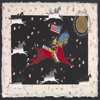

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Lakota Horse Mask," a striking artwork by Jim Yellowhawk, created in 2008 and measuring 12 x 9 inches. The piece is crafted with acrylic on paper and adorned with gold leaf, showcasing the artistic talents of the Cheyenne River Lakota artist. The horse, a significant figure in Native American culture, is depicted against a dark background adorned with leaves, symbolizing the connection between horses and Native peoples. Horses have been pivotal in the lives of many Native tribes, serving as both companions and essential allies in times of peace and war alike. Originally native to the Americas over 40 million years ago, horses became extinct until their return in 1493 with Columbus. This a

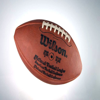

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wilson Duke football, a key artifact from Super Bowl XIV, held on January 20, 1980, at the Rose Bowl in Pasadena, California. The Wilson Sporting Goods Company introduced this football in the early 1940s, renowned for its premium leather and robust construction, featuring sewn ends, lock-stitch seams, and triple lining. Since Super Bowl II in 1968, it has been the official ball of the NFL championship game. The showcased football was pivotal during the Steelers' match against the Rams, where the Steelers emerged victorious with a score of 31-19. This victory marked the Steelers' fourth Super Bowl win and solidified Terry Bradshaw's legacy as he earned the Most Valuable Player award for

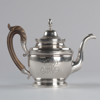

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable silver teapot crafted by Peter Bentzon, an American artisan active from around 1783 to after 1850. The teapot is characterized by its elegant oval vase shape, gracefully supported by a spreading pedestal foot. Its hinged domed cover is topped with an acorn finial, while the curved spout is adorned with an incised patera. The teapot's handle is crafted from wood, enhancing its decorative appeal. Notably, the piece bears the engraved monogram "MC" and the name "Rebecca Dawson" along the bottom rim, indicating its historical significance. This exquisite object measures 7 inches in height, 12 inches in width, and 5 inches in depth, and is part of the Smithsonian National Museum of

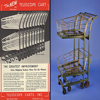

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History highlights the Telescoping Shopping Cart, an invention that revolutionized shopping convenience. Developed by Orla E. Watson in 1946, this cart features a design that allows multiple carts to nest together, thereby requiring only one-fifth of the space of a standard cart when parked. This innovation first appeared in 1947 at Floyd's Super Market in Kansas City. The exhibit is part of the museum's first comprehensive exhibition on food history, which explores the significant changes in food consumption and shopping practices in postwar America. For further insights into the evolution of food shopping and related innovations, visitors are encouraged to check

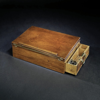

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Thomas Jefferson's portable writing desk, an essential tool used during the drafting of the Declaration of Independence in 1776. Jefferson, appointed by the Second Continental Congress to write this foundational document, designed the desk with a hinged writing board and a locking drawer for storing writing essentials. The declaration, adopted on July 4, serves as a testament to the American spirit and the ideals of liberty. The desk accompanied Jefferson throughout his life, including his presidency, and was later gifted to his granddaughter by his daughter in 1825. This artifact was sold to the U.S. government in 1870 and was initially housed at the Patent Office before its transfer to t

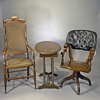

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important artifact: Abraham Lincoln's chair, which he used during the historic moment of his second inauguration on March 4, 1865. Located in the National Museum of American History, this chair is part of a larger display that highlights the significance of Lincoln's life and legacy. Crafted from wood, the chair is notable for its high back and armrests, as well as a unique spindle design on its legs. It was gifted to the Smithsonian Institution by Lincoln Isham, Lincoln's great-grandson, in 1958. This chair is just one piece of a larger collection that includes over 1,000 artifacts related to Lincoln, showcasing his enduring influence on American history and politics. Visitors can also

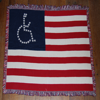

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-stitched lap blanket that has been modified to include the universal access symbol, created by disability-rights advocates from the American Disabled for Attendant Programs Today (ADAPT). The blanket, made from cotton and measuring 129 cm by 95 cm, serves as a powerful symbol of the fight for civil rights among disabled individuals. ADAPT was founded in 1983 in Denver, emerging from the broader disability rights movement that gained momentum after World War II, as individuals with disabilities began to organize and advocate for their rights. The blanket's design, which incorporates stars onto a commercial American flag, is particularly poignant, highlighting the belief that civil ri

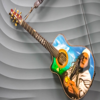

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer renowned for his vallenato music. Vallenato, a lively genre from Colombia's Atlantic coast, blends European instruments like the accordion with poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, this music was performed by rural workers and cowboys, but in the 1990s, Vives and other artists transformed it by incorporating pop and rock elements, thus broadening its appeal both within Colombia and among Latino communities worldwide. The guitar on display, handmade by a Colombian luthier, showcases an airbrushed portrait of an Arhuaco and was last played by Vives during a concert at the 

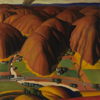

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "The Cumberland Valley," a striking painting by Ross Dickinson, an artist whose work captures the essence of California's Central Valley during the Great Depression. Created for the Public Works of Art Project, the painting depicts a lush valley surrounded by dry, rugged hills, symbolizing the hope that drew many to California during the Dust Bowl's devastation. However, Dickinson's portrayal also includes a small fire in the foreground and a larger plume of smoke rising from the distant hills, serving as a stark reminder of the dangers that accompany nature's beauty. This artwork not only illustrates the beauty of California's landscape but also reflects the complex realities of life duri

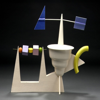

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the innovative work of Peter Shire, an artist born in Los Angeles in 1947. It showcases a teapot that exemplifies Shire's unique approach to ceramic art, characterized by its playful use of color and form. The teapot is composed of several pieces, including a large, open-topped vase, a whimsical weathervane, and a collection of small, abstract forms made from clay slabs. Shire's intention was to challenge and democratize the concept of "tea-time," making it a more inclusive experience that invites interaction and curiosity. After 1985, he shifted his focus to furniture design, but his teapots remain a significant part of his legacy. This piece is part of the Smithsonian American Art Museum

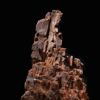

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Spotsylvania tree stump, a poignant artifact from the Civil War era, currently displayed at the Smithsonian's National Museum of American History. The stump dates back to 1864–65 and was once part of a large oak tree located in a serene meadow near Spotsylvania Court House, Virginia. On May 12, 1864, the area became the site of intense fighting between Confederate forces and Union troops, resulting in the meadow being renamed the Bloody Angle. The oak tree was caught in the crossfire, with several Minié balls still embedded in its wood, serving as a stark reminder of the violence that unfolded. The Battle of Spotsylvania Court House, which lasted from May 8 to May 21, resulted in appro

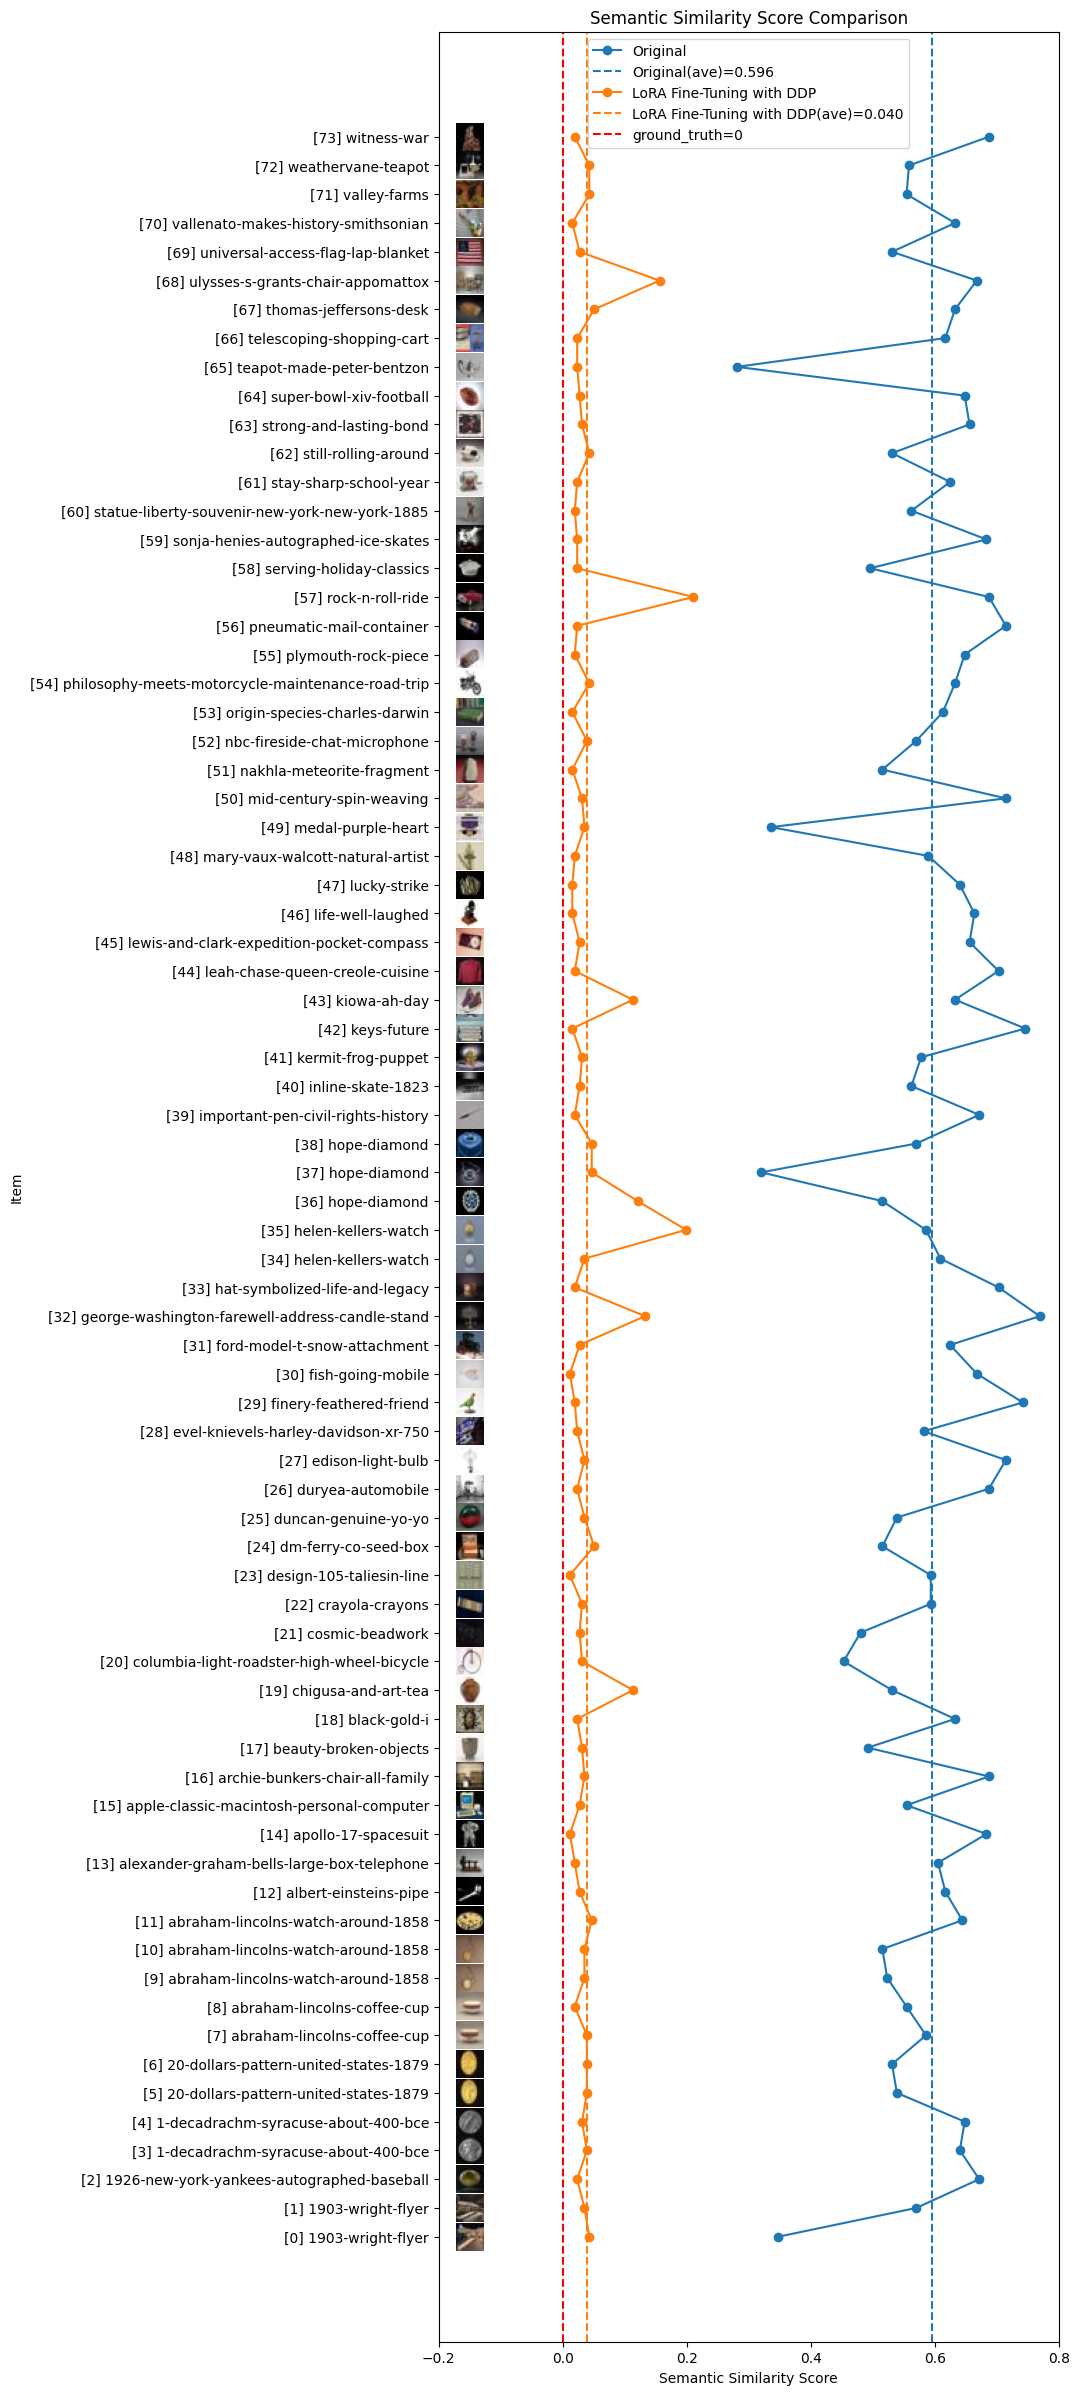

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(lora_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 14)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('LoRA Fine-Tuning with DDP', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 3.4 Save the Fine-Tuned Model Locally  

In [3]:
# Merge base model with LoRA adapter
print(f'==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...')
merged_model = lora_model.merge_and_unload()

# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(merged_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(merged_model, './results/model_info/finetuned_model_parameters.txt')
merged_model.save_pretrained(save_directory='./results/finetuned_model')


==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...
==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
model.vision_model.e